In [106]:
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import describe
import datetime
from datetime import timedelta as timedelta
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn.preprocessing import StandardScaler
import sklearn.utils as sku
from scipy import signal
import os, sys
sys.path.append( '/home/ugrads/c/clearloveyanzhen/CufflessBP/bioz_processing' )
import sicong_util as su
import sicong_duck_path as sp
import sicong_duck_path as sdp
plt.rcParams.update({'font.size': 13})
import seaborn as sns
import scipy as sp # for signal processing
from scipy import signal
from scipy.spatial import distance
import IPython.display as ipd
import random
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader , TensorDataset
import torch.autograd as autograd
from torch import Tensor

In [183]:
def label_binary_converter(in_x, in_y, bp_type='sbp', in_vals=[140, 150], thre=[-3, +3], out_vals=[0,1], balanced_out=True):
    # in_x=X; in_y=y; bp_type='sbp'; in_vals=[120, 160]; thre=[-2, +2]; out_vals=[0,1]; balanced_out=True
    if bp_type == 'sbp':
        out_y=in_y[:,0]
    else:
        out_y=in_y[:,1]
    out_y0=np.zeros(out_y[(out_y >= in_vals[0]+thre[0])&(out_y <= in_vals[0]+thre[1])].shape)
    out_y1=np.ones(out_y[(out_y >= in_vals[1]+thre[0])&(out_y <= in_vals[1]+thre[1])].shape)
    out_x0 = in_x[(out_y >= in_vals[0]+thre[0])&(out_y <= in_vals[0]+thre[1]),:]
    out_x1 = in_x[(out_y >= in_vals[1]+thre[0])&(out_y <= in_vals[1]+thre[1]),:]
    if balanced_out:
        len_out=min(out_y0.shape, out_y1.shape)[0]
        out_x0, out_y0 = sku.resample(out_x0, out_y0, n_samples=len_out)
        out_x1, out_y1 = sku.resample(out_x1, out_y1, n_samples=len_out)
    out_x = np.concatenate((out_x0, out_x1))
    out_y = np.concatenate((out_y0, out_y1))
    out_x, out_y = sku.resample(out_x, out_y)
    return out_x, out_y

In [184]:
X = np.load('X_file.npy')
y = np.load('y_file.npy')
X, y = label_binary_converter(in_x=X, in_y=y)

In [185]:
X = X[:,-1800:]

In [186]:
X.shape

(4824, 1800)

In [187]:
mm = MinMaxScaler()
X = mm.fit_transform(X)

In [188]:
from sklearn import svm
import xgboost
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
# lr = LogisticRegression(random_state=0)
xgb = xgboost.XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)
models_used = {'xgb':xgb}
model_names = {'xgb':'XGBoost'}
colors_used = {'xgb': 'blue'}
scores = {}
for model in models_used:
    scores[model] = cross_val_score(models_used[model], X, y, cv=10, scoring='f1')

xgb
0.898883291124126


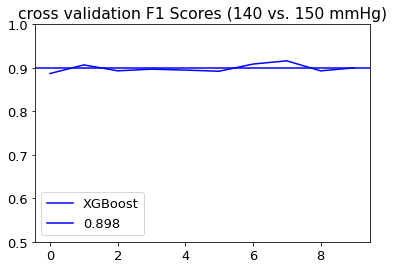

In [190]:
plt.title('cross validation F1 Scores (140 vs. 150 mmHg)')
for model in scores:
    plt.plot(scores[model], color=colors_used[model], label=model_names[model])
    plt.axhline(np.mean(scores[model]), color=colors_used[model], label=str(np.mean(scores[model]))[:5])
    plt.ylim([0.5, 1])
    print(model)
    print(np.mean(scores[model]))
plt.legend()

In [194]:
for model in models_used:
    models_used[model].fit(X_train, y_train)
    y_pred = models_used[model].predict(X_test)
    print(f1_score(y_test, y_pred))

0.8691392582225332


/home/ugrads/c/clearloveyanzhen/miniconda3/envs/torch/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Confusion Matrix of subset of data')

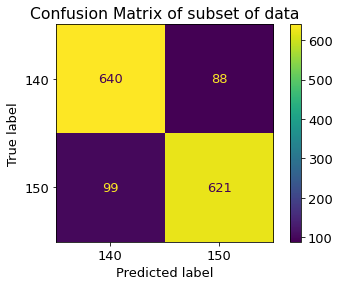

In [196]:
plot_confusion_matrix(models_used['xgb'], X_test, y_test, display_labels=['140', '150'])
plt.title('Confusion Matrix of subset of data')